### Файл `main.ipynb`
Тетрадка с кодом применения
модели, которая при запуске Run без
дополнительных модификаций должна считывать
предоставленную на github тестовую выборку
test.xlsx и добавлять в
test.xlsx колонку с прогнозом целого числа N (на сколько недель вперед
необходимо проводить закупку) для каждой даты, присутствующей в test.

### Клон репозитория

In [ ]:
!git clone https://github.com/samoletpanfilov/reinforcement_task.git

fatal: destination path 'reinforcement_task' already exists and is not an empty directory.


### Установка зависимостей

In [ ]:
!pip install tsfresh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

import xgboost as xgb

import pickle

%matplotlib inline
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Загрузка данных

Ссылка на Google Disk с весами моделей: https://drive.google.com/drive/folders/1w4VogagY5hBjHy55C4b4wvlEtaCQTCeU

In [ ]:
!git clone https://github.com/lyaminartemiy/samolet_hack.git

fatal: destination path 'samolet_hack' already exists and is not an empty directory.


In [ ]:
train = pd.read_excel("/content/reinforcement_task/data/train.xlsx")
test = pd.read_excel("/content/reinforcement_task/data/test.xlsx")

# Загрузка весов моделей XGBoost
model0 = pickle.load(open("/content/samolet_hack/data/xgb_reg1.pkl", "rb"))
model1 = pickle.load(open("/content/samolet_hack/data/xgb_reg2.pkl", "rb"))
model2 = pickle.load(open("/content/samolet_hack/data/xgb_reg3.pkl", "rb"))

### Предобработка данных

In [ ]:
# Подготовка тренировочной выборки
df_train = pd.DataFrame()
df_train['Date'] = pd.to_datetime(train['dt'])
df_train['Price'] = train['Цена на арматуру']
df_train['istest'] = 0

# Подготовка тестовой выборки
df_test = pd.DataFrame()
df_test['Date'] = pd.to_datetime(test['dt'])
df_test['Price'] = test['Цена на арматуру']
df_test['istest'] = 1

# Конкатинируем в один датасет с метрой `istest`
raw = pd.concat((df_train, df_test)).reset_index(drop=True)

# Выделяем временные признаки
raw["day_sin"] = np.sin(raw["Date"].dt.day)
raw["day_cos"] = np.cos(raw["Date"].dt.day)

# Создадим матрицы со сдвигом, то есть сделаем так, чтобы значение
# цены на следующую неделю являлось "неизвестным для модели"
X = raw.drop(columns=['Price']).iloc[:-1, :]
y = raw['Price'].values[1:]

X['Price_target'] = y
X['Price_source'] = raw['Price'].values[:-1]

# Подсчитаем разницу между текущим и прошлым значением цены на покупку арматуры
price_diff = X['Price_source'] - X['Price_target']

# Удаляем первую строку
X = X.drop([0])

# Добавляем разницу в цене
X['Price_Diff'] = price_diff.values[:-1]

# Удаление ненужных столбцов
y = X['Price_target']
X = X.drop(columns=['Price_target', 'Date'])

In [ ]:
# Используем следующий набор параметров

# Рассчитываются коэффициенты skewness и kurtosis, считается, сколько раз
# повторялось значение минимума и максимума, различные квантили, оконные
# статистики, автокорреляции и т. д.
settings_efficient = settings.EfficientFCParameters()
len(settings_efficient)

# Подготовка фреймов длины 5
data_fot_tsfresh = X['Price_source'].values
indexes = list(range(len(data_fot_tsfresh), 4, -1))

ts_for_tsfresh = []

for i in range(len(indexes)):
    indexes_ts = indexes[i:i+6][::-1]
    values_ts = data_fot_tsfresh[indexes_ts[0]:indexes_ts[-1]]
    # print(values_ts)
    if len(values_ts) < 5:
        break
    ts_for_tsfresh.append(values_ts)

ts_for_tsfresh = pd.DataFrame(ts_for_tsfresh[::-1])

# Создание фрейма необходимого формата для выделения признаков
data_long = pd.DataFrame({'data': ts_for_tsfresh.values.flatten(),
              'id': np.repeat(np.array(ts_for_tsfresh.index), 5)})

# Генерация признаков
X_tsfresh = extract_features(data_long, column_id='id', impute_function=impute, default_fc_parameters=settings_efficient)

# Удаление пустых строк
X = X.drop(list(range(1, 10)))
y = y.drop(list(range(1, 10)))

# Reset индексов
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Добавляем выделенные признаки в тренировочную и тестовую выборки
for col in X_tsfresh.columns:
    X[col] = X_tsfresh[col]

Feature Extraction: 100%|██████████| 417/417 [00:55<00:00,  7.52it/s]


### Прогнозирование временного ряда для тестовой выборки

In [ ]:
data_for_test = X[X['istest'] == 1]
data_for_test = data_for_test.drop(columns=['istest'])

ypred = (model0.predict(data_for_test) +
         model1.predict(data_for_test) +
         model2.predict(data_for_test)) / 3

In [ ]:
result = pd.DataFrame({'real': y[X['istest'] == 1][1:],
              'pred': ypred[:-1]})
result['error'] = result['real'] - result['pred']
result.tail(12)

,real,pred,error
405,42500,41482.625000,1017.375000
406,42700,41298.484375,1401.515625
407,42700,43658.636719,-958.636719
408,42700,43210.984375,-510.984375
409,42800,43278.792969,-478.792969
410,42800,43167.613281,-367.613281
411,44500,43846.417969,653.582031
412,44500,44338.363281,161.636719
413,46000,44907.082031,1092.917969
414,49200,44770.500000,4429.500000


In [ ]:
# Подсчет метрик прогноза на отложенной выборке
print("MAE на тестовой выборке:", mean_absolute_error(y[X['istest'] == 1], ypred))
print("MSE на тестовой выборке:", mean_squared_error(y[X['istest'] == 1], ypred))

MAE на тестовой выборке: 653.5309606481482
MSE на тестовой выборке: 620056.1352821633


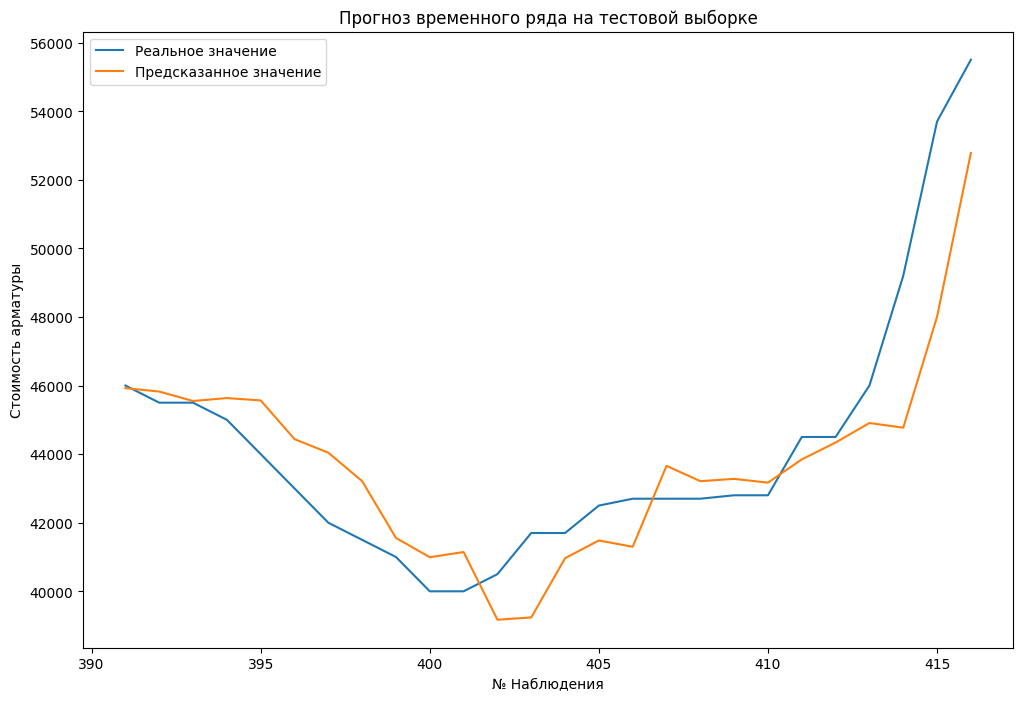

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=100)


plt.plot(result['real'], label='Реальное значение');
plt.plot(result['pred'], label='Предсказанное значение');
plt.title('Прогноз временного ряда на тестовой выборке')
plt.xlabel('№ Наблюдения')
plt.ylabel('Стоимость арматуры')
plt.legend();

# Распределение объема закупок арматуры по предсказанным значениям ряда

In [ ]:
# Функция для распределения объема закупок
def get_minimum_spend(data):
    values = data.iloc[:, 1].astype(float)
    markers = []
    pos = 0
    total = 0
    while pos < len(values):
        temp = np.diff(values[pos:pos+10])
        temp = np.insert(temp, 0, np.nan)
        temp[1:] = np.cumsum(temp[1:])
        counter = 0
        for counter in range(len(temp)):
            counter += 1
            if pos + counter == len(values):
                break
            if counter == len(temp):
                break
            if temp[counter] < 0:
                break
        markers.append(counter)
        markers.extend([0 for _ in range(counter-1)])
        total += counter * values[pos]
        pos += counter
    return(markers, total)

In [ ]:
source_price = test['Цена на арматуру']
predictions_costs = pd.DataFrame(np.array(list(y[X['istest'] == 0].tail(1).values) + list(ypred)))
test['Цена на арматуру'] = predictions_costs

In [ ]:
# Потраченная сумма на арматуру
markers, total = get_minimum_spend(test)

In [ ]:
test['Объем'] = markers
print("Общая сумма затрат, учитывая прогноз цены: ", total)

Общая сумма затрат, учитывая прогноз цены:  1187374.43359375


In [ ]:
test['Цена на арматуру'] = source_price
test.to_excel("submission.xlsx", index=False)
test

,dt,Цена на арматуру,Объем
0,2022-09-05,46000,1
1,2022-09-12,46000,1
2,2022-09-19,46000,1
3,2022-09-26,45500,3
4,2022-10-03,45500,0
5,2022-10-10,45000,0
6,2022-10-17,44000,1
7,2022-10-24,43000,1
8,2022-10-31,42000,1
9,2022-11-07,41500,1


In [ ]:
def decision_prices(test):

    test = test.set_index('dt')
    tender_price = test['Цена на арматуру']
    decision = test['Объем']
    start_date = test.index.min()
    end_date = test.index.max()

    _results = []
    _active_weeks = 0
    for report_date in pd.date_range(start_date, end_date, freq='W-MON'):
        if _active_weeks == 0:  # Пришла пора нового тендера
            _fixed_price = tender_price.loc[report_date]
            _active_weeks = int(decision.loc[report_date])
        _results.append(_fixed_price)
        _active_weeks += -1
    cost = sum(_results)
    return cost # Возвращаем затраты на периоде

In [ ]:
print("Общая сумма затрат, учитывая знание цены на арматуру: ", decision_prices(test))

Общая сумма затрат, учитывая знание цены на арматуру:  1194000


In [ ]:
test = test.drop(columns=['Объем'])

# "Идеальный" вариант
markers, total = get_minimum_spend(test)

In [ ]:
test['Объем'] = markers
test

,dt,Цена на арматуру,Объем
0,2022-09-05,46000,3
1,2022-09-12,46000,0
2,2022-09-19,46000,0
3,2022-09-26,45500,2
4,2022-10-03,45500,0
5,2022-10-10,45000,1
6,2022-10-17,44000,1
7,2022-10-24,43000,1
8,2022-10-31,42000,1
9,2022-11-07,41500,1
